Upload file


Saving data.csv to data (4).csv
File uploaded: data (4).csv


,metric,value
0,accuracy,0.9211


,precision,recall,f1-score,support
0,0.909091,0.972222,0.939597,72.000000
1,0.945946,0.833333,0.886076,42.000000
accuracy,0.921053,0.921053,0.921053,0.921053
macro avg,0.927518,0.902778,0.912837,114.000000
weighted avg,0.922669,0.921053,0.919879,114.000000


,pred_0,pred_1
true_0,70,2
true_1,7,35


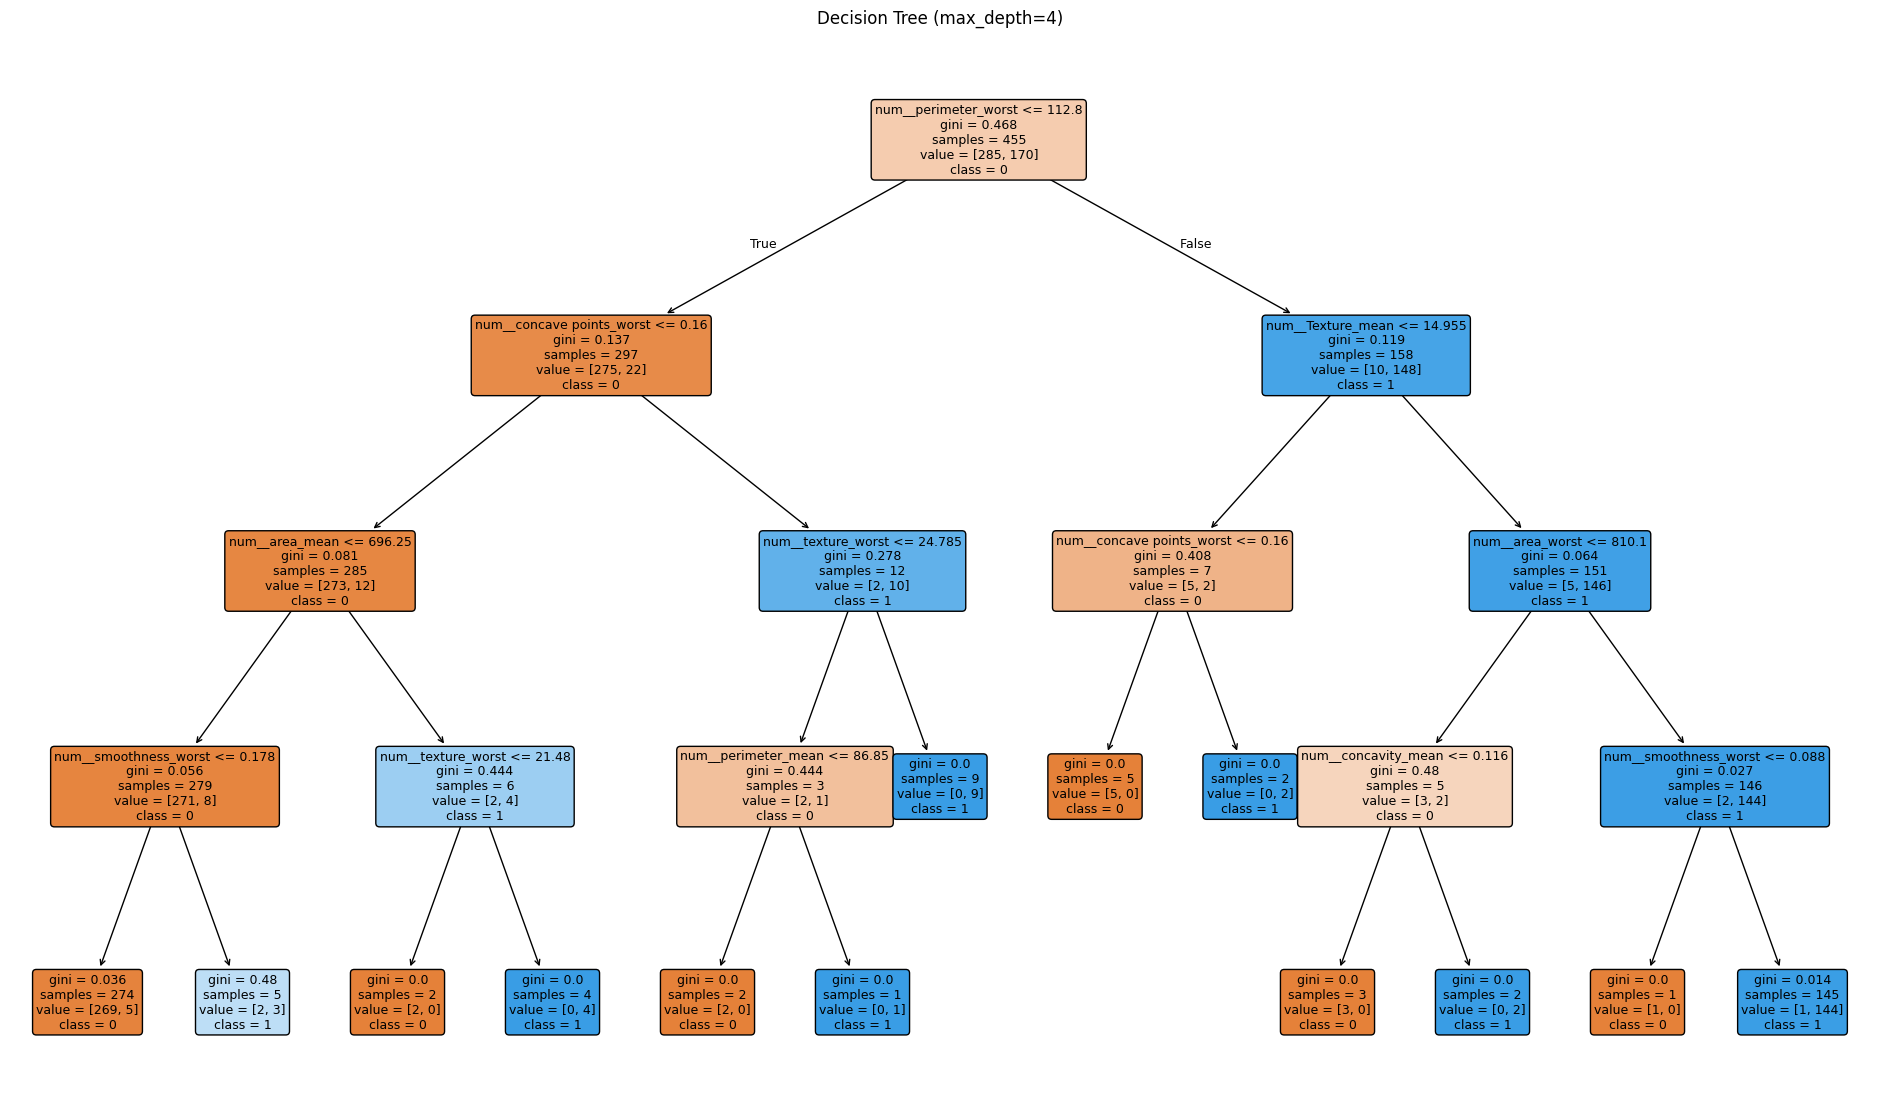

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Upload file")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file selected.")
FILENAME = list(uploaded.keys())[0]
print(f"File uploaded: {FILENAME}")

df = pd.read_csv(FILENAME)
TARGET_COLUMN = None
common_target_names = {"diagnosis","class","target","label","outcome","status","Class"}
id_like = [c for c in df.columns if "id" in c.lower()]
df_wo_id = df.drop(columns=id_like, errors="ignore")
for c in df_wo_id.columns:
    if c.lower() in {n.lower() for n in common_target_names}:
        TARGET_COLUMN = c
        break
if TARGET_COLUMN is None:
    candidates = [c for c in df_wo_id.columns if df_wo_id[c].dropna().nunique()==2]
    TARGET_COLUMN = candidates[0] if candidates else df_wo_id.columns[-1]
df = df.dropna(subset=[TARGET_COLUMN]).copy()
if df[TARGET_COLUMN].dtype == object:
    top2 = df[TARGET_COLUMN].value_counts().index.tolist()[:2]
    df[TARGET_COLUMN] = df[TARGET_COLUMN].map({top2[0]:0, top2[1]:1})

y = df[TARGET_COLUMN].astype(int)
X = df.drop(columns=[TARGET_COLUMN])

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_features),
    ],
    remainder="drop",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = Pipeline(steps=[("prep", preprocess),
                     ("model", DecisionTreeClassifier(random_state=42, max_depth=4))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc_table = pd.DataFrame({"metric": ["accuracy"], "value": [round(acc, 4)]})
display(acc_table)

report = classification_report(y_test, y_pred, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
display(report_df)

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
cm_df = pd.DataFrame(cm,
                     index=[f"true_{c}" for c in sorted(y.unique())],
                     columns=[f"pred_{c}" for c in sorted(y.unique())])
display(cm_df)

prep = clf.named_steps["prep"]
tree = clf.named_steps["model"]
try:
    feat_names = prep.get_feature_names_out()
except:
    feat_names = np.array(numeric_features + [f"{c}__onehot" for c in categorical_features])

plt.figure(figsize=(24, 14))
plot_tree(
    tree,
    feature_names=feat_names,
    class_names=[str(c) for c in sorted(y.unique())],
    filled=True,
    rounded=True,
    impurity=True,
    fontsize=9
)
plt.title("Decision Tree (max_depth=4)")
plt.show()
